# You Draw I Draw

# Team Member

### 107062514 賴鵬仁
### 107062616 傅品捷
### 107065513 姚定嘉

## Dataset

In [1]:
# import the required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=8,suppress=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [2]:
# function used to draw a sketch
def get_bounds(data, factor=10):
  """Return bounds of data."""
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0

  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
  return (min_x, max_x, min_y, max_y)


def draw_strokes(data,
                 svg_filename='/tmp/sketch_rnn/svg/sample.svg',
                 factor=0.2,
                 show_pen_sequence=False,
                 who_draw_the_stroke=None):
  if not os.path.exists(os.path.dirname(svg_filename)):
    os.makedirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "M"
  xs = []
  ys = []
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "M"
    elif (command != "L"):
      command = "L"
    else:
      command = ""
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    xs.append(abs_x)
    ys.append(abs_y)
    lift_pen = data[i, 2]
    p += command + str(abs_x) + "," + str(abs_y) + " "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
  color = 'black'
  if show_pen_sequence:
    turn = 0
    for i in range(1, len(xs)):
      dwg.add(
          dwg.text(
              '{}'.format(i),
              insert=(xs[i], ys[i]),
              font_size="10px",
              fill=color))
      if who_draw_the_stroke is not None:
        if data[i, 2] == 1:
          color = 'red' if who_draw_the_stroke[turn] == 0 else 'black'
          turn += 1
  display(SVG(dwg.tostring()))

In [3]:
# load data
data = np.load('./dataset/microphone.full.npz',encoding="latin1")
train_sketches = data['train']
valid_sketches = data['valid']
test_sketches = data['test']
print('num train: {}'.format(len(train_sketches)))
print('num valid: {}'.format(len(valid_sketches)))
print('num test: {}'.format(len(test_sketches)))

num train: 103938
num valid: 2500
num test: 2500


[[  -4   -6    0]
 [ -15   -1    0]
 [ -28   13    0]
 [ -10   18    0]
 [  -2   15    0]
 [  13   20    0]
 [  22    4    0]
 [   7   -2    0]
 [  12   -8    0]
 [   6   -9    0]
 [   0  -31    0]
 [  -6  -16    0]
 [  -7   -4    1]
 [ -38   13    0]
 [   5   37    0]
 [   6   18    1]
 [   1  -62    0]
 [  10   67    1]
 [   1  -73    0]
 [  13   67    0]
 [   5    8    1]
 [  -8  -68    0]
 [  12   47    1]
 [ -50  -20    0]
 [  24  -11    0]
 [  22   -6    1]
 [ -51   36    0]
 [  33  -14    0]
 [  21   -5    1]
 [ -39   25    0]
 [  27   -3    0]
 [  11   -8    1]
 [ -37   32    0]
 [   0   33    0]
 [   5    2    0]
 [  38   -7    0]
 [ -13  -32    1]
 [ -16    7    0]
 [   4   11    1]
 [-188  -38    0]
 [   0   20    0]
 [  -5   26    0]
 [   6    2    0]
 [  86   -7    0]
 [  38    1    0]
 [   2   -5    0]
 [  -8  -47    0]
 [ -18    6    0]
 [ -47    6    0]
 [ -51    3    0]
 [ -18   -1    1]
 [  57    0    0]
 [  -7   -9    0]
 [  -1   -8    0]
 [  12  -18    0]
 [   9   -

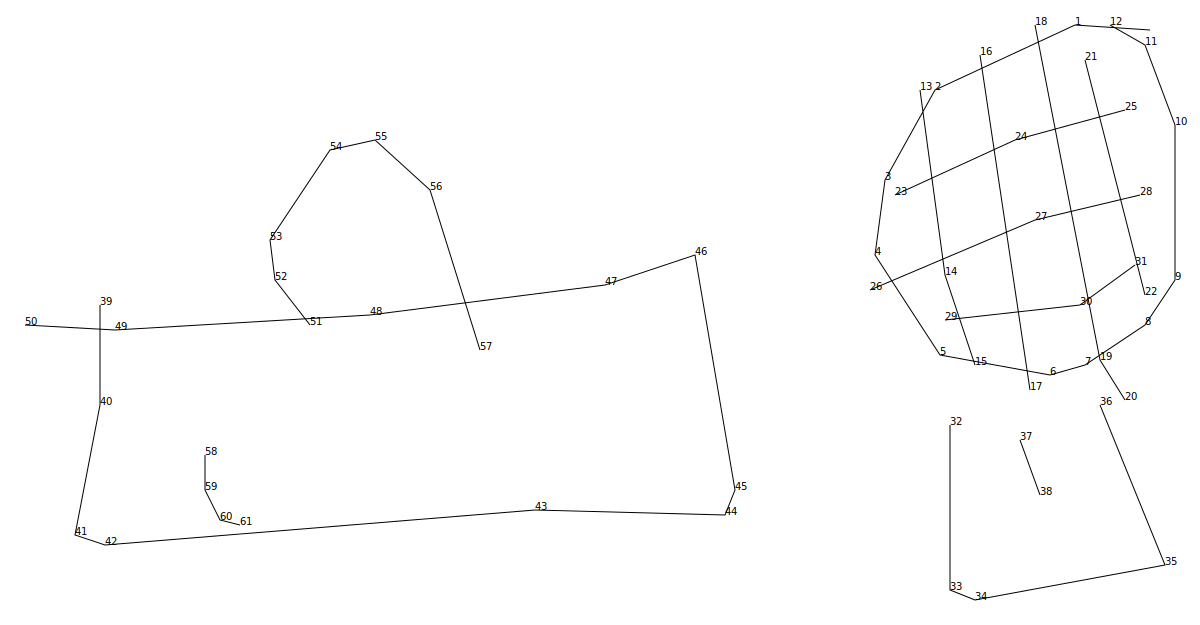

In [4]:
# see data format and draw it
print(train_sketches[0])
draw_strokes(train_sketches[0], show_pen_sequence=True)


In [5]:
def preprocess(sketches, limit=1000):
  raw_data = []
  seq_len = []
  count_data = 0

  for i in range(len(sketches)):
    data = sketches[i]
    count_data += 1
    # removes large gaps from the data
    data = np.minimum(data, limit)
    data = np.maximum(data, -limit)
    data = np.array(data, dtype=np.float32)
    raw_data.append(data)
    seq_len.append(len(data))
  seq_len = np.array(seq_len)  # nstrokes for each sketch
  idx = np.argsort(seq_len)
  sketches = []
  for i in range(len(seq_len)):
    sketches.append(raw_data[idx[i]])
  return raw_data


def normalize(sketches):
  """Normalize entire dataset (delta_x, delta_y) to [-1,1]."""
  result = []
  for i in range(len(sketches)):
    tmp = sketches[i]
    sketches[i][:, :2] /= np.max(np.abs(sketches[i][:, :2]))
    result.append(tmp)
  return result


def to_big_strokes(strokes):
  """Converts from stroke-3 to stroke-5 format and pads to given length, but does not insert special start token)."""

  result = np.zeros((len(strokes), 5), dtype=float)
  l = len(strokes)
  result[0:l, 0:2] = strokes[:, 0:2]
  result[0:l, 3] = strokes[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result


def to_big_sketches(sketches):
  result = []
  for i in range(len(sketches)):
    sketch = to_big_strokes(sketches[i])
    result.append(sketch)
  return result


def to_normal_strokes(big_strokes):
  """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
  l = 0
  for i in range(len(big_strokes)):
    if big_strokes[i, 4] > 0:
      l = i
      break
  if l == 0:
    l = len(big_strokes)
  result = np.zeros((l, 3))
  result[:, 0:2] = big_strokes[0:l, 0:2]
  result[:, 2] = big_strokes[0:l, 3]
  return result

In [6]:
# preprocess sketches
train_sketches = preprocess(train_sketches)
valid_sketches = preprocess(valid_sketches)
test_sketches = preprocess(test_sketches)

train_sketches = normalize(train_sketches)
valid_sketches = normalize(valid_sketches)
test_sketches = normalize(test_sketches)

# convert to stroke-5 format
train_sketches = to_big_sketches(train_sketches)
valid_sketches = to_big_sketches(valid_sketches)
test_sketches = to_big_sketches(test_sketches)

[[-0.0212766  -0.03191489  0.        ]
 [-0.07978723 -0.00531915  0.        ]
 [-0.14893617  0.06914894  0.        ]
 [-0.05319149  0.09574468  0.        ]
 [-0.0106383   0.07978723  0.        ]
 [ 0.06914894  0.10638298  0.        ]
 [ 0.11702128  0.0212766   0.        ]
 [ 0.03723404 -0.0106383   0.        ]
 [ 0.06382979 -0.04255319  0.        ]
 [ 0.03191489 -0.04787234  0.        ]
 [ 0.         -0.16489361  0.        ]
 [-0.03191489 -0.08510638  0.        ]
 [-0.03723404 -0.0212766   1.        ]
 [-0.20212767  0.06914894  0.        ]
 [ 0.02659575  0.19680852  0.        ]
 [ 0.03191489  0.09574468  1.        ]
 [ 0.00531915 -0.32978722  0.        ]
 [ 0.05319149  0.35638297  1.        ]
 [ 0.00531915 -0.38829789  0.        ]
 [ 0.06914894  0.35638297  0.        ]
 [ 0.02659575  0.04255319  1.        ]
 [-0.04255319 -0.36170211  0.        ]
 [ 0.06382979  0.25        1.        ]
 [-0.26595744 -0.10638298  0.        ]
 [ 0.12765957 -0.05851064  0.        ]
 [ 0.11702128 -0.03191489

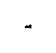

In [7]:
print(to_normal_strokes(train_sketches[0]))
draw_strokes(to_normal_strokes(train_sketches[0]))

In [8]:
# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):

  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max + x_min) * 0.5
    return x_start - center_loc, x_end

  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0] * grid_space + grid_space * 0.5
    grid_x = grid_loc[1] * grid_space_x + grid_space_x * 0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x + loc_x
    new_y_pos = grid_y + loc_y
    result.append([new_x_pos - x_pos, new_y_pos - y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos + delta_pos[0]
    y_pos = new_y_pos + delta_pos[1]
  return np.array(result)

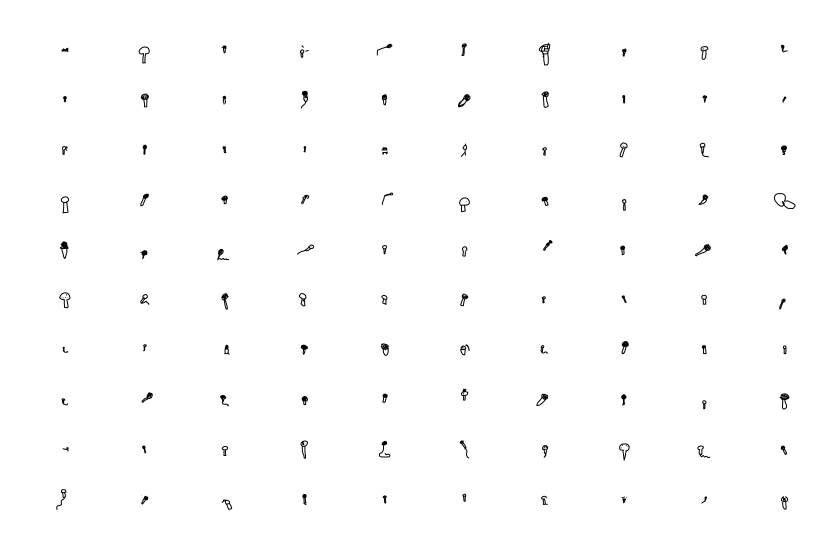

In [9]:
sketches_grid = []
for i in range(10):
  for j in range(10):
    sketches_grid.append(
        [to_normal_strokes(train_sketches[i * 10 + j]), [i, j]])
sketches_grid = make_grid_svg(sketches_grid)
draw_strokes(sketches_grid)

In [10]:
# import the required libraries
import time
import random
import json
import tensorflow as tf

In [11]:
# function used to generate next point
def adjust_temp(pi_pdf, temp):
  pi_pdf = np.log(pi_pdf) / temp
  pi_pdf -= pi_pdf.max()
  pi_pdf = np.exp(pi_pdf)
  pi_pdf /= pi_pdf.sum()
  return pi_pdf


def get_pi_idx(x, pdf, temp=1.0, greedy=False):
  """Samples from a pdf, optionally greedily."""
  if greedy:
    return np.argmax(pdf)
  pdf = adjust_temp(np.copy(pdf), temp)
  accumulate = 0
  for i in range(0, pdf.size):
    accumulate += pdf[i]
    if accumulate >= x:
      return i
  tf.logging.info('Error with sampling ensemble.')
  return -1


def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
  if greedy:
    return mu1, mu2
  mean = [mu1, mu2]
  s1 *= temp * temp
  s2 *= temp * temp
  cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
  x = np.random.multivariate_normal(mean, cov, 1)
  return x[0][0], x[0][1]

## Model: Sketch-RNN

### Fintuned Method :

在model loss的部分，我們作了一些小改動，將原本的RNN_loss乘上定義好的reward，並將比賽過後的sketch當作input吃進來，當LOSS越大，希望他朝贏的方向前進。在此我們有試過RNN_LOSS + finetuned loss，也試過(1-alpha) * RNN_LOSS + (alpha) * finetuned loss。最後最成功的方法是RNN_loss * finetuned loss(Reward)。

In [12]:
class SRNN_Model():

  def __init__(self, hps, model_name='sketch_rnn'):
    self.hps = hps
    self.model_name = model_name
    with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
      self.build_model(hps)

  def build_model(self, hps):

    # input and output
    self.batch_size = tf.placeholder(
        dtype=tf.int32, shape=[], name='batch_size')
    self.input_sequence = tf.placeholder(
        dtype=tf.float32,
        shape=[None, hps.max_seq_len + 1, 5],
        name='input_sequence')
    input_sequence = self.input_sequence[:, :-1]
    output_sequence = self.input_sequence[:, 1:, :]
    self.lstm_cell = tf.nn.rnn_cell.LSTMCell(hps.dec_rnn_size)
    self.zero_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
    output, _ = tf.nn.dynamic_rnn(
        self.lstm_cell, input_sequence, initial_state=self.zero_state)
    output = tf.reshape(output, [-1, hps.dec_rnn_size])

    # for each input timestamp, output parameters for mixture of gaussian
    num_hidden = hps.num_mixture * 6 + 3

    def feed_forward(output):
      with tf.variable_scope('feed_forward', reuse=tf.AUTO_REUSE):
        return tf.layers.dense(output, num_hidden)

    output = feed_forward(output)
    ##############################################################################
    """
        Loss for mixture of multivariate gaussian. Given (prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
        we want the mixture to output high probility P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3),
        see equation (9) at https://arxiv.org/pdf/1704.03477.pdf
        
        parameters:
            pi: weight of each mixture, shape (batch_size*max_seq_len, num_mixture)
            mu1, mu2: mu of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            sigma1, sigma2: sigma of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            corr: correction of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
        """
    output_params = tf.split(
        output, num_or_size_splits=[3] + [hps.num_mixture] * 6, axis=1)
    output_pen_logits, output_mixture_pi, output_mu1, output_mu2, output_sigma1, output_sigma2, output_corr = output_params

    # softmax all the pi's and pen states:
    output_mixture_pi = tf.nn.softmax(output_mixture_pi)
    output_pen_pi = tf.nn.softmax(output_pen_logits)

    # exponentiate the sigmas and also make corr between -1 and 1.
    output_sigma1 = tf.exp(output_sigma1)
    output_sigma2 = tf.exp(output_sigma2)
    output_corr = tf.tanh(output_corr)

    x1 = tf.reshape(output_sequence[:, :, 0], [-1, 1])
    x2 = tf.reshape(output_sequence[:, :, 1], [-1, 1])

    def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
      """
            Returns P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
            see equation (24) of http://arxiv.org/abs/1308.0850 or 
            https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
            """
      norm1 = tf.subtract(x1, mu1)
      norm2 = tf.subtract(x2, mu2)
      s1s2 = tf.multiply(s1, s2)
      # eq 25
      z = (tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2)) -
           2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2))
      neg_rho = 1 - tf.square(rho) + 1e-6  # avoid divide by zero
      result = tf.exp(tf.div(-z, 2 * neg_rho))
      denom = 2 * np.pi * tf.multiply(s1s2, tf.sqrt(neg_rho))
      result = tf.div(result, denom)
      self.denom = denom
      self.neg_rho = neg_rho
      self.s1s2 = s1s2
      self.s1 = s1
      self.s2 = s2
      return result

    point_prob = tf_2d_normal(x1, x2, output_mu1, output_mu2, output_sigma1,
                              output_sigma2, output_corr)
    point_prob = tf.multiply(
        point_prob, output_mixture_pi)  # multiply weight of each mixture
    point_prob = tf.reduce_sum(point_prob, axis=1)

    # loss for indicating if pen should stop
    pen_labels = tf.reshape(output_sequence[:, :, 2:],
                            [-1, 3])  # (batch_size*max_seq_len ,3)
    pen_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=pen_labels, logits=output_pen_logits)
    self.pen_loss = tf.reduce_mean(pen_loss)

    # loss for delta x,y
    delta_xy_loss = -tf.log(point_prob + 1e-6)  # avoid log(0)
    mask = 1.0 - pen_labels[:, 2]
    mask = tf.reshape(mask, [-1, 1])
    delta_xy_loss = delta_xy_loss * mask
    self.delta_xy_loss = tf.reduce_mean(delta_xy_loss)
    self.finetune_loss = tf.placeholder(
        dtype=tf.float32,
        shape=None,
        name='finetune_loss')

    self.loss = (self.pen_loss + self.delta_xy_loss)*self.finetune_loss

    # optimize rnn
    self.global_step = tf.get_variable(
        name='global_step', initializer=tf.constant(0.), trainable=False)
    self.learning_rate = tf.get_variable(
        name='learning_rate',
        initializer=tf.constant(hps.learning_rate),
        trainable=False)
    optimizer = tf.train.AdamOptimizer(self.learning_rate)
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                 self.model_name + '/')
    grad_vars = optimizer.compute_gradients(self.loss, var_list=var_list)
    grad_vars = [(tf.clip_by_value(grad, -hps.grad_clip, hps.grad_clip), var)
                 for grad, var in grad_vars]
    self.train_op = optimizer.apply_gradients(
        grad_vars, global_step=self.global_step, name='train_step')

    #################### tensor for generating a point ############################
    self.prev_state = self.lstm_cell.zero_state(1, dtype=tf.float32)
    self.prev_point = tf.placeholder(
        tf.float32, shape=[1, 5], name='prev_point')
    output, self.next_state = self.lstm_cell(self.prev_point, self.prev_state)
    output = tf.reshape(output, [-1, hps.dec_rnn_size])
    output = feed_forward(output)
    self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr = \
                                                          tf.split(output[:,3:], num_or_size_splits=6, axis=1)
    pen_logits = output[:, :3]
    self.output_pi = tf.nn.softmax(self.output_pi)
    self.pen_pi = tf.nn.softmax(pen_logits)
    self.output_sigma1 = tf.exp(self.output_sigma1)
    self.output_sigma2 = tf.exp(self.output_sigma2)
    self.output_corr = tf.tanh(self.output_corr)

  def generate_stroke(self, sess, prev_sketch, temperature=0.1, greedy=False):
    """
        *****************************IMPORTANT*****************************
        1. your model must have this function, or error happen when evaluation.
        2. the length of stroke must less than 10, which means you can at most generate 10 points.
        *******************************************************************
        this function return a stroke given previous generated sketch
        """
    # feed previous sketch to get hidden state
    prev_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
    for i in range(len(prev_sketch) - 1):
      feed_dict = {
          self.prev_state: prev_state,
          self.prev_point: [prev_sketch[i]],
      }
      prev_state = sess.run(self.next_state, feed_dict)

    # start to generate next stroke
    prev_point = [prev_sketch[-1]]
    generated_stroke = []
    while len(generated_stroke) < 10:
      feed_dict = {
          self.prev_state: prev_state,
          self.prev_point: prev_point,
      }
      params = sess.run([
          self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1,
          self.output_sigma2, self.output_corr, self.pen_pi, self.next_state
      ], feed_dict)

      [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen,
       next_state] = params

      # sample index of bivarite normal in mixture to use
      idx = get_pi_idx(np.random.random(), o_pi[0], temperature, greedy)

      # sample index of pen state
      idx_eos = get_pi_idx(np.random.random(), o_pen[0], temperature, greedy)
      eos = [0, 0, 0]
      eos[idx_eos] = 1

      # use one bivarite normal to generate next (delta_x, delta_y)
      next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                            o_sigma1[0][idx], o_sigma2[0][idx],
                                            o_corr[0][idx],
                                            np.sqrt(temperature), greedy)

      prev_point = np.zeros([1, 5])
      prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
      prev_state = next_state
      generated_stroke.append(prev_point)

      # if this stroke stop
      if prev_point[0][4] == 1:
        generated_stroke[-1][0][:2] = 0
      if prev_point[0][4] == 1 or prev_point[0][3] == 1:
        break
    # pen state should end with p2=1 or p3=1
    if generated_stroke[-1][0][2] == 1:
      generated_stroke[-1][0][2:] = [0., 1., 0.]
    return np.concatenate(generated_stroke, axis=0)

  def generate_sketches(self, sess, num_generate, temperature, greedy=False):
    initial_point = np.array([[0., 0., 1., 0., 0.]])
    initial_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
    return_sketches = []
    for i in range(num_generate):
      sketch = [initial_point]
      prev_point = initial_point
      prev_state = initial_state
      for j in range(self.hps.max_seq_len):
        feed_dict = {
            self.prev_state: prev_state,
            self.prev_point: prev_point,
        }
        params = sess.run([
            self.output_pi, self.output_mu1, self.output_mu2,
            self.output_sigma1, self.output_sigma2, self.output_corr,
            self.pen_pi, self.next_state
        ], feed_dict)

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen,
         next_state] = params
        idx = get_pi_idx(random.random(), o_pi[0], temperature, greedy)

        idx_eos = get_pi_idx(random.random(), o_pen[0], temperature, greedy)
        eos = [0, 0, 0]
        eos[idx_eos] = 1

        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                              o_sigma1[0][idx],
                                              o_sigma2[0][idx], o_corr[0][idx],
                                              np.sqrt(temperature), greedy)

        prev_point = np.zeros([1, 5])
        prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
        prev_state = next_state

        # select a multivariate normal in mixture to draw next point
        sketch.append(prev_point)
        if prev_point[0][4] == 1:
          sketch[-1][0][:2] = 0
          break
      return_sketches.append(np.concatenate(sketch, axis=0))
    return return_sketches

  def train(self,
            sess,
            x_train,
            x_valid,
            x_test,
            finetune_loss,
            num_epoch=20,
            batch_size=100,
            patience=20):
    start = time.time()
    best_valid_cost = np.inf
    counter = 0
    num_epoch = 1
    batch_size = 1
    for epoch in range(num_epoch):

      def gen_batch(x, loss):
        shuffle_idx = np.random.permutation(len(x))
        x = x[shuffle_idx]
        loss = np.array(loss)[shuffle_idx]
        num_batch = len(x) // batch_size
        for i in range(num_batch):
          yield (x[i * batch_size:(i + 1) * batch_size], loss[i * batch_size:(i + 1) * batch_size])

      losses = []
      delta_xy_losses = []
      pen_losses = []
      for obj in gen_batch(x_train, finetune_loss):
        x_batch = obj[0]
        f_loss = obj[1][0]
        #print(x_batch)
        print(f_loss)
        step = sess.run(self.global_step)
        curr_learning_rate = ((hps.learning_rate - hps.min_learning_rate) *
                              (hps.decay_rate)**step + hps.min_learning_rate)
        feed_dict = {
            self.input_sequence: x_batch,
            self.learning_rate: curr_learning_rate,
            self.batch_size: len(x_batch),
            self.finetune_loss: f_loss
        }
        (loss, delta_xy_loss, pen_loss, _) = sess.run(
            [self.loss, self.delta_xy_loss, self.pen_loss,
             self.train_op], feed_dict)
        losses.append(loss)
        delta_xy_losses.append(delta_xy_loss)
        pen_losses.append(pen_loss)
        if step % 20 == 0 and step > 0:
          end = time.time()
          time_taken = end - start
          tf.logging.info((
              'step: {}, learning_rate: {:.4f}, loss: {:.4f}, xy_loss: {:.4f}, '
              + 'pen_loss: {:.4f}, finetune_loss: {:.4f}, time_taken: {:.2f}').format(
                  step, curr_learning_rate,
                  np.mean(losses),
                  np.mean(delta_xy_losses), np.mean(pen_losses), np.mean(finetune_loss), time_taken))
          losses = []
          delta_xy_losses = []
          pen_losses = []
          start = time.time()
        if step % 1000 == 0 and step > 0:
          N = 10
          sketches = self.generate_sketches(
              sess, num_generate=N, temperature=0.5)
          reconstructions = []
          for i in range(N):
            reconstructions.append([to_normal_strokes(sketches[i]), [0, i]])
          stroke_grid = make_grid_svg(reconstructions)
          draw_strokes(stroke_grid)

        if step % self.hps.save_every == 0 and step > 0:
          start = time.time()
          test_losses = []
          test_delta_xy_losses = []
          test_pen_losses = []
          for x_batch in gen_batch(x_valid):
            feed_dict = {
                self.input_sequence: x_batch,
                self.batch_size: len(x_batch)
            }

            (loss, delta_xy_loss, pen_loss) = sess.run(
                [self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
            test_losses.append(loss)
            test_delta_xy_losses.append(delta_xy_loss)
            test_pen_losses.append(pen_loss)

          end = time.time()
          time_taken = end - start
          tf.logging.info(
              ('validation, step: {}, loss: {:.4f}, xy_loss: {:.4f}, ' +
               'pen_loss: {:.4f}, time_taken: {:.2f}').format(
                   step,
                   np.mean(test_losses),
                   np.mean(test_delta_xy_losses),
                   np.mean(test_pen_losses), time_taken))
          start = time.time()

          if np.mean(test_losses) < best_valid_cost:
            best_valid_cost = np.mean(test_losses)
            self.save_model(sess, step=step)
            test_losses = []
            test_delta_xy_losses = []
            test_pen_losses = []
            for x_batch in gen_batch(x_test):
              feed_dict = {
                  self.input_sequence: x_batch,
                  self.batch_size: len(x_batch)
              }

              (loss, delta_xy_loss, pen_loss) = sess.run(
                  [self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
              test_losses.append(loss)
              test_delta_xy_losses.append(delta_xy_loss)
              test_pen_losses.append(pen_loss)

            end = time.time()
            time_taken = end - start
            tf.logging.info(
                ('testing, step: {}, loss: {:.4f}, xy_loss: {:.4f}, ' +
                 'pen_loss: {:.4f}, time_taken: {:.2f}').format(
                     step,
                     np.mean(test_losses),
                     np.mean(test_delta_xy_losses),
                     np.mean(test_pen_losses), time_taken))
            counter = 0
          else:
            counter += 1
            if counter > patience:
              tf.logging.info('early stop!!')
              return

  def save_model(self, sess, checkpoint_dir='./checkpoints', step=None):
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(
        tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name +
                          '/'))
    if step is not None:
      saver.save(
          sess, os.path.join(checkpoint_dir, self.model_name), global_step=step)
      tf.logging.info('model save to {}-{}'.format(
          os.path.join(checkpoint_dir, self.model_name), step))
    else:
      saver.save(sess, os.path.join(checkpoint_dir, self.model_name))
      tf.logging.info('model save to {}'.format(
          os.path.join(checkpoint_dir, self.model_name)))

  def load_model(self, sess, checkpoint_dir='./checkpoints', step=None):
    """
        *****************************IMPORTANT*****************************
        1. your model must have this function, or error happen when evaluation.
        *******************************************************************
        this function load weight to sess
        """
    saver = tf.train.Saver(
        tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name +
                          '/'))
    if step is not None:
      saver.restore(sess,
                    os.path.join(checkpoint_dir,
                                 self.model_name + '-{}'.format(step)))
    else:
      saver.restore(sess, os.path.join(checkpoint_dir, self.model_name))

In [13]:
def pad_data(sketches, max_seq_len):
  """Pad the batch to be stroke-5 bigger format as described in paper."""
  result = np.zeros((len(sketches), max_seq_len + 1, 5), dtype=float)
  for i in range(len(sketches)):
    l = len(sketches[i])
    result[i, 0:l, :] = sketches[i][:, :]
    result[i, l:, 4] = 1

    # put in the first token, as described in sketch-rnn methodology
    result[i, 1:, :] = result[i, :-1, :]
    result[i, 0, :] = 0
    result[i, 0, 2] = 1  # setting S_0 from paper.
  return result


def get_max_len(sketches):
  """Return the maximum length of an array of strokes."""
  max_len = 0
  for sketch in sketches:
    ml = len(sketch)
    if ml > max_len:
      max_len = ml
  return max_len

In [14]:
def copy_hparams(hparams):
  """Return a copy of an HParams instance."""
  return tf.contrib.training.HParams(**hparams.values())


def get_default_hparams():
  """Return default HParams for sketch-rnn."""
  hparams = tf.contrib.training.HParams(
      data_set=['aaron_sheep.npz'],  # Our dataset.
      save_every=2000,  # Number of batches per checkpoint creation.
      max_seq_len=250,  # Not used. Will be changed by model. [Eliminate?]
      dec_rnn_size=1024,  # Size of decoder.
      batch_size=100,  # Minibatch size. Recommend leaving at 100.
      grad_clip=1.0,  # Gradient clipping. Recommend leaving at 1.0.
      num_mixture=20,  # Number of mixtures in Gaussian mixture model.
      learning_rate=0.001,  # Learning rate.
      decay_rate=0.9999,  # Learning rate decay per minibatch.
      kl_decay_rate=0.99995,  # KL annealing decay rate per minibatch.
      min_learning_rate=0.00001,  # Minimum learning rate.
      use_recurrent_dropout=True,  # Dropout with memory loss. Recomended
      recurrent_dropout_prob=0.90,  # Probability of recurrent dropout keep.
      use_input_dropout=False,  # Input dropout. Recommend leaving False.
      input_dropout_prob=0.90,  # Probability of input dropout keep.
      use_output_dropout=False,  # Output droput. Recommend leaving False.
      output_dropout_prob=0.90,  # Probability of output dropout keep.
      random_scale_factor=0.15,  # Random scaling data augmention proportion.
      augment_stroke_prob=0.10,  # Point dropping augmentation proportion.
      conditional=True,  # When False, use unconditional decoder-only model.
      is_training=True  # Is model training? Recommend keeping true.
  )
  return hparams

In [15]:
hps = get_default_hparams()


In [16]:

tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
random.seed(123)
model = SRNN_Model(hps, model_name='microphone')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


## Evaluation

在此我們是用原始的evaluation model(只有4類)，因為在preliminary contest的結果，我們已經過TA-60了，所以就沒有再去用新的 evaluation model(5類)。

In [17]:
def render_imgs(strokes, img_size, max_seq_len):
  """ 
    convert 5-strokes format to image
        args:
            sketches: shape(data_size, max_seq_len, 5)
    """

  xy = np.cumsum(strokes[:, :, 0:2], axis=1)  # (data_size, max_seq, 2)
  min_xy = np.min(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  xy = xy - min_xy  # (data_size, max_seq, 2)
  max_xy = np.max(xy, axis=(1), keepdims=True)  # (data_size, 1, 2)
  max_xy = np.where(max_xy == 0, np.ones([len(strokes), 1, 2]),
                    max_xy)  # avoid divide by 0
  xy = xy / max_xy  # (data_size, max_seq, 2)
  xy = xy * (img_size - 1)  # (data_size, max_seq, 2)

  strokes_idx = np.tile(np.arange(len(strokes))[:, None],
                        [1, img_size])  # (data_size, img_size)
  interpolate_line = np.tile(
      np.reshape(
          np.arange(img_size).astype(np.float32) / (img_size - 1),
          [1, img_size, 1]), [len(strokes), 1, 2])

  def interpolate(p1, p2):
    p1 = np.reshape(p1, [-1, 1, 2])
    p2 = np.reshape(p2, [-1, 1, 2])
    return (1 - interpolate_line
           ) * p1 + interpolate_line * p2  # (data_size, img_size, 2)

  images = np.zeros([len(strokes), img_size, img_size])
  render_next = np.ones(len(images), dtype=np.bool)
  for idx in range(max_seq_len - 1):
    p1 = xy[:, idx]
    p2 = xy[:, idx + 1]
    # if p1 is connect to p2, draw a line between them
    connect = np.where(
        np.logical_and(strokes[:, idx, 3] > strokes[:, idx, 2],
                       strokes[:, idx, 3] > strokes[:, idx, 4]),
        np.zeros(len(images), dtype=np.bool),
        np.ones(len(images), dtype=np.bool))

    p_interpolate_line = interpolate(p1, p2).astype(
        np.int32)  # (data_size, img_size, 2)
    x_idx = np.where(connect[:, None], p_interpolate_line[:, :, 0],
                     np.tile(xy[:, idx, None, 0], [1,
                                                   img_size]).astype(np.int32))
    y_idx = np.where(connect[:, None], p_interpolate_line[:, :, 1],
                     np.tile(xy[:, idx, None, 1], [1,
                                                   img_size]).astype(np.int32))
    images[strokes_idx, x_idx, y_idx] = 1
  images = np.rot90(images, -1, axes=(1, 2))
  return images


class Evaluate_model:

  def __init__(self, image_size, model_name='evaluate_model'):
    with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
      self.input_x = tf.placeholder(
          tf.float32, [None, image_size, image_size], name="input_x")
      self.labels = tf.placeholder(tf.int32, [None], name="input_y")
      self.keep_rate = tf.placeholder(tf.float32, [], name="keep_rate")
      self.model_name = model_name

    
      self.global_step = tf.get_variable(
        name='global_step', initializer=tf.constant(0.), trainable=False)
    
      hidden = tf.reshape(self.input_x, [-1, image_size, image_size, 1])
      hidden = tf.layers.conv2d(
          hidden,
          filters=64,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
      hidden = tf.layers.conv2d(
          hidden,
          filters=64,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
      hidden = tf.layers.max_pooling2d(
          hidden, pool_size=3, strides=2, padding='same')
      hidden = tf.layers.conv2d(
          hidden,
          filters=128,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
      hidden = tf.layers.conv2d(
          hidden,
          filters=128,
          kernel_size=5,
          activation=tf.nn.relu,
          padding='same')
      hidden = tf.nn.lrn(
          hidden, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
      hidden = tf.layers.max_pooling2d(
          hidden, pool_size=3, strides=2, padding='same')
      hidden = tf.layers.flatten(hidden)
      hidden = tf.layers.dense(hidden, 384)
      hidden = tf.layers.dense(hidden, 192)
      hidden = tf.layers.dense(hidden, 96)

      # Add dropout
      with tf.variable_scope("dropout"):
        hidden = tf.layers.dropout(hidden, 1 - self.keep_rate)
      hidden = tf.layers.dense(hidden, 4)
      # label of balloon: 0
      # label of bulb: 1
      # label of ice: 2
      # label of microphone: 3
      self.predictions = tf.nn.softmax(hidden)
      argmax_prediction = tf.cast(tf.argmax(self.predictions, axis=1), tf.int32)

      self.accuracy = tf.reduce_mean(
          tf.to_float(tf.equal(argmax_prediction, self.labels)))

      # CalculateMean cross-entropy loss
      losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=hidden, labels=self.labels)
      self.loss = tf.reduce_mean(losses)
      for v in tf.trainable_variables():
        self.loss += 0.001 * tf.nn.l2_loss(v)

      # Define Training procedure
      self.lr = tf.Variable(0.001, trainable=False)
      optimizer = tf.train.AdamOptimizer(self.lr)
      grads_and_vars = optimizer.compute_gradients(
          self.loss,
          var_list=[v for v in tf.global_variables() if model_name in v.name])
      self.train_op = optimizer.apply_gradients(
          grads_and_vars, global_step=self.global_step)
    
  def load_model(self, sess, checkpoint_dir='./checkpoints', step=None):
    saver = tf.train.Saver(
        tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name +
                          '/'))
    if step is not None:
      saver.restore(sess,
                    os.path.join(checkpoint_dir,
                                 self.model_name + '-{}'.format(step)))
    else:
      saver.restore(sess, os.path.join(checkpoint_dir, self.model_name))  

# Play Game

在此我們是了許多嘗試:
1.每畫一個stroke之後的sketch當作input sketch。

2.每一場game結束之後的sketch當作input sketch。

此為input sketch 我們有做過的嘗試。

接下來reward部分

1.把比完賽的sketch丟進evaluation model得到的prediction的softmax_cross_entropy_loss加進SRNN model的loss function裡繼續train。

2.加進loss function的reward從(prediction的softmax_cross_entropy_loss)改成(1-prediction_probability)

3.仿照 policy gradient 的 loss : -log(P) * reward ， P有試過設為predict probability，也是過設成定值。

經過跟助教的討論:

當 reward>0 的時候，代表以後的行為要越像這次的行為。
當 reward=0 的時候，無法做任何改變。 
當 reward<0 的時候，代表以後的行為要越不像這次的行為。

4.我們後期都朝著把reward設成定值，乘進去model loss，reward的部分tune過了好幾種嘗試。

5.發現RNN_loss有正有負，所以我們認為當reward是正的時候，RNN_loss也要是正的，這樣才會朝著這個方向前進。

6.跑過不只100個game，希望讓training data 可以更多。

7.經過finetuned後，結果是有微幅成長的，所以我們希望再用finetuned完的model再繼續比賽，讓他越來越強。但效果不彰。

### 最後成功的方法: RNN_loss * reward ，win game 時 reward給正的定值， lose game 時 reward給負的定值，draw 時 reward 給0。

In [18]:
# Game
def play_game(player1, player2):
    """
        player1, player2: dict containing 12 sketch-model. 
        In your model, you need to implement *generate_stroke* function.
    """
    player1_win = 0
    player2_win = 0
    draw = 0
    generated_sketches = []
    who_draw_the_strokes = []

    # load evaluate model
    evaluate_model = Evaluate_model(image_size=64, model_name='evaluate_model')

    evaluate_model.load_model(sess)

    THRESHOLD = 150  # if a sketch longer than threshold, stop
      # we will use different random seed when evaluating your model
    np.random.seed(123)
    random.seed(123)
    num_games = 100
    sketches = []  # record sketch
    results = []  # record result class
    rendered_imgs = []  # record rendered image
    who_draw_the_strokes_game = []
    class_to_draw1 = 'balloon'
    class_to_draw2 = 'bulb'
    win_reward = 2
    lose_reward = -2
    draw_reward = 0

    finetune_sketches = []
    finetune_losses = []
    for i in range(num_games):
        player1_stop = False
        player2_stop = False
        who_draw_the_stroke = []
        input_sequence = np.array([[0., 0., 1., 0., 0.]])  # start token
        turn = int(i >= 50)  # after 50 games, player2 draw first

        while len(input_sequence) < THRESHOLD:
            if turn % 2 == 0 and not player1_stop:
                generated_stroke = player1.generate_stroke(
                    sess, input_sequence)
                try:  # if your stroke not follow rule, skip your turn
                    generated_stroke = check_stroke(generated_stroke)
                except:
                    turn += 1
                    continue
                who_draw_the_stroke.append(0)
                if generated_stroke[-1][4] == 1:
                    player1_stop = True
                    generated_stroke[-1][2:] = [0., 1., 0.]
            elif turn % 2 == 1 and not player2_stop:
                generated_stroke = player2.generate_stroke(
                    sess, input_sequence)
                try:  # if your stroke not follow rule, skip your turn
                    generated_stroke = check_stroke(generated_stroke)
                except:
                    turn += 1
                    continue
                who_draw_the_stroke.append(1)
                if generated_stroke[-1][4] == 1:
                    player2_stop = True
                    generated_stroke[-1][2:] = [0., 1., 0.]
            elif player1_stop and player2_stop:
                input_sequence[-1][2:] = [0., 0., 1.]
                break
            else:
                turn += 1
                continue
            input_sequence = np.concatenate(
                [input_sequence, generated_stroke], axis=0)
            turn += 1
            result, rendered_img = predict(sess, evaluate_model, input_sequence,
                                         class_to_draw1, class_to_draw2)

          # after turn 4, we check if game end
            if turn >= 4 and result != 'draw':
                break

            if input_sequence[-1][4] == 1:
                break
        
        
        if(result == class_to_draw1):
            finetune_sketches.append(input_sequence)
            finetune_losses.append(win_reward)
        elif(result == class_to_draw2):  
            finetune_sketches.append(input_sequence)    
            finetune_losses.append(lose_reward)        
        else:
            finetune_sketches.append(input_sequence)
            finetune_losses.append(draw_reward)
        
        results.append(result)
        sketches.append(input_sequence)
        rendered_imgs.append(rendered_img)
        who_draw_the_strokes_game.append(who_draw_the_stroke)
      # plot rendered images
    print('player1 draw {}, player2 draw {}'.format(class_to_draw1,
                                                    class_to_draw2))
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))
    axs = axs.flatten()
    for i in range(len(rendered_imgs)):
        axs[i].imshow(rendered_imgs[i], cmap='gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(results[i])
    plt.show()
    print(
        'In 100 games, {} of sketches look like {}, {} of sketches look like {}, {} of sketches look like others'.
        format((np.array(results) == class_to_draw1).sum(), class_to_draw1, (
            np.array(results) == class_to_draw2).sum(), class_to_draw2, (
                np.array(results) == 'draw').sum()))
    player1_win += (np.array(results) == class_to_draw1).sum()
    player2_win += (np.array(results) == class_to_draw2).sum()
    draw += (np.array(results) == 'draw').sum()
    generated_sketches.append(sketches)
    who_draw_the_strokes.append(who_draw_the_strokes_game)
    print('player1 win {} games, player2 win {} games, {} games draw'.format(
      player1_win, player2_win, draw))
    return generated_sketches, who_draw_the_strokes, finetune_sketches, finetune_losses


def predict(sess, evaluate_model, sketch, class_to_draw1, class_to_draw2):
    THRESHOLD = 0.75

  # render sketch to image
    img_size = 64
    max_seq_len = len(sketch)
    rendered_imgs = render_imgs(np.array([sketch]), img_size, max_seq_len)

  # run cnn prediction
    feed_dict = {
      evaluate_model.input_x: rendered_imgs,
      evaluate_model.keep_rate: 1.0,
    }
    predictions = sess.run(evaluate_model.predictions, feed_dict=feed_dict)

    encode_dict = {
      'balloon': 0,  # label of balloon
      'bulb': 1,  # label of bulb
      'ice': 2,  # label of ice
      'microphone': 3  # label of microphone
    }
    p1 = predictions[0, encode_dict[class_to_draw1]]
    p2 = predictions[0, encode_dict[class_to_draw2]]
    if p1 > p2 and p1 > THRESHOLD:
        return class_to_draw1, rendered_imgs[0]
    elif p1 < p2 and p2 > THRESHOLD:
        return class_to_draw2, rendered_imgs[0]
    else:
        return 'draw', rendered_imgs[0]


def check_stroke(stroke):
    if len(stroke) > 10:
        raise Exception
    for i in range(len(stroke) - 1):
        if (stroke[-1][2:] != [1., 0., 0.]).all() and (stroke[-1][2:] != [
        0., 1., 0.
        ]).all() and (stroke[-1][2:] != [0., 0., 1.]).all():
            raise Exception
    if (stroke[-1][2:] != [0., 1., 0.]).all() and (stroke[-1][2:] != [0., 0., 1.
                                                                   ]).all():
        raise Exception
    stroke[:, :2] = np.clip(stroke[:, :2], -1, 1)
    return stroke

play game我們也適用舊的，因為preliminary contest結果已過benchmark，在這邊就沒有作改動了。

In [19]:
'''
# load model
draw_model = {}
for class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:
  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:
    if class_to_draw == class_to_compete:
      continue
    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)
    model_name = '{}-{}'.format(
        class_to_draw, class_to_compete
    )  # please change model name to team-{team_number}-{class}-{class_to_compete}
    with tf.device('/cpu:0'):
      draw_model[dict_key] = SRNN_Model(hps, model_name=model_name)
      draw_model[dict_key].load_model(sess)

import ta_60_model as player2
hps = player2.get_default_hparams()
draw_model_ta_60 = {}
for class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:
  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:
    if class_to_draw == class_to_compete:
      continue
    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)
    model_name = '{}-{}-60'.format(class_to_draw, class_to_compete)
    with tf.device('/cpu:0'):
      draw_model_ta_60[dict_key] = player2.SRNN_Model(
          hps, model_name=model_name)
      draw_model_ta_60[dict_key].load_model(sess)
'''

"\n# load model\ndraw_model = {}\nfor class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:\n  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:\n    if class_to_draw == class_to_compete:\n      continue\n    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)\n    model_name = '{}-{}'.format(\n        class_to_draw, class_to_compete\n    )  # please change model name to team-{team_number}-{class}-{class_to_compete}\n    with tf.device('/cpu:0'):\n      draw_model[dict_key] = SRNN_Model(hps, model_name=model_name)\n      draw_model[dict_key].load_model(sess)\n\nimport ta_60_model as player2\nhps = player2.get_default_hparams()\ndraw_model_ta_60 = {}\nfor class_to_draw in ['balloon', 'bulb', 'ice', 'microphone']:\n  for class_to_compete in ['balloon', 'bulb', 'ice', 'microphone']:\n    if class_to_draw == class_to_compete:\n      continue\n    dict_key = '{}-{}'.format(class_to_draw, class_to_compete)\n    model_name = '{}-{}-60'.format(class_to_draw, class_t

In [20]:
# # load model
pretrain_model_1 = SRNN_Model(hps, model_name='balloon')
import ta_60_model as player2
hps = player2.get_default_hparams()
pretrain_model_2 = player2.SRNN_Model(hps, model_name='bulb')

sess.run(tf.global_variables_initializer())

pretrain_model_1.load_model(sess, step=64000)
pretrain_model_2.load_model(sess, step=64000)

INFO:tensorflow:Restoring parameters from ./checkpoints\balloon-64000
INFO:tensorflow:Restoring parameters from ./checkpoints\bulb-64000


INFO:tensorflow:Restoring parameters from ./checkpoints\evaluate_model
player1 draw balloon, player2 draw bulb


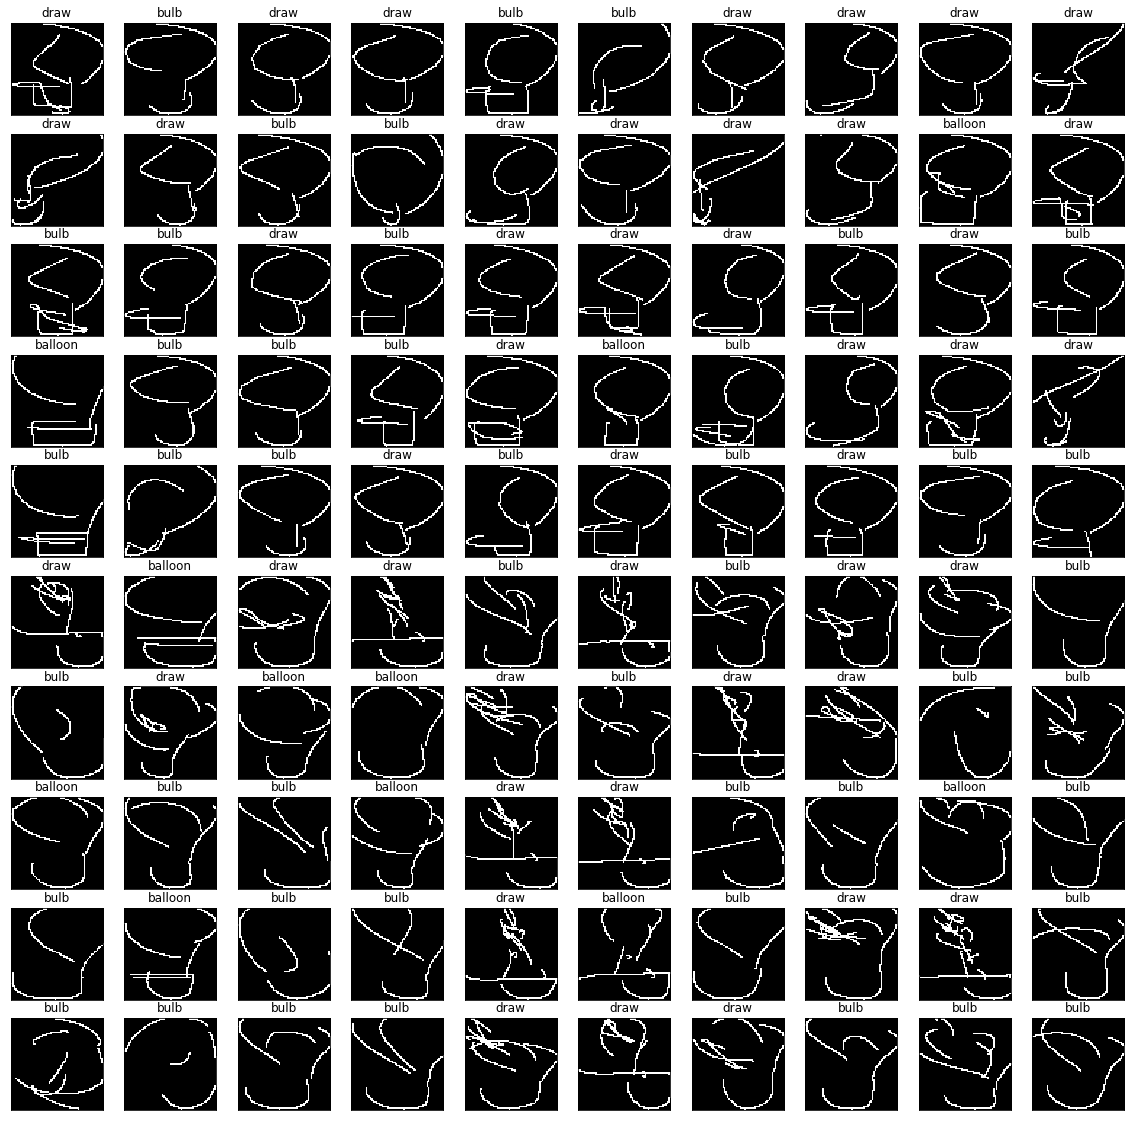

In 100 games, 11 of sketches look like balloon, 45 of sketches look like bulb, 44 of sketches look like others
player1 win 11 games, player2 win 45 games, 44 games draw


In [21]:
result, who_draw_the_strokes, sketches_finetune, finetune_loss = play_game(pretrain_model_1, pretrain_model_2)

(100, 152, 5)
INFO:tensorflow:Restoring parameters from ./checkpoints\balloon-64000
INFO:tensorflow:Restoring parameters from ./checkpoints\bulb-64000
INFO:tensorflow:Restoring parameters from ./checkpoints\bulb-balloon-60
0
-2
-2
0
-2
0
-2
0
-2
2
-2
0
-2
0
-2
-2
0
0
-2
-2
-2
INFO:tensorflow:step: 20.0, learning_rate: 0.0000, loss: -1.1243, xy_loss: 0.7725, pen_loss: 0.1464, finetune_loss: -0.6800, time_taken: 5.15
0
-2
-2
-2
2
-2
-2
2
-2
0
-2
-2
-2
0
0
-2
-2
-2
-2
0
INFO:tensorflow:step: 40.0, learning_rate: 0.0000, loss: -2.1729, xy_loss: 1.6876, pen_loss: 0.1511, finetune_loss: -0.6800, time_taken: 3.57
-2
-2
-2
0
0
-2
0
0
-2
0
0
2
0
0
-2
0
0
0
2
0
INFO:tensorflow:step: 60.0, learning_rate: 0.0000, loss: -0.9163, xy_loss: 1.7030, pen_loss: 0.1943, finetune_loss: -0.6800, time_taken: 3.54
2
-2
2
-2
2
0
-2
-2
-2
-2
0
0
0
0
2
2
0
0
-2
0
INFO:tensorflow:step: 80.0, learning_rate: 0.0000, loss: -0.4882, xy_loss: 1.9995, pen_loss: 0.1881, finetune_loss: -0.6800, time_taken: 3.51
0
-2
-2
-

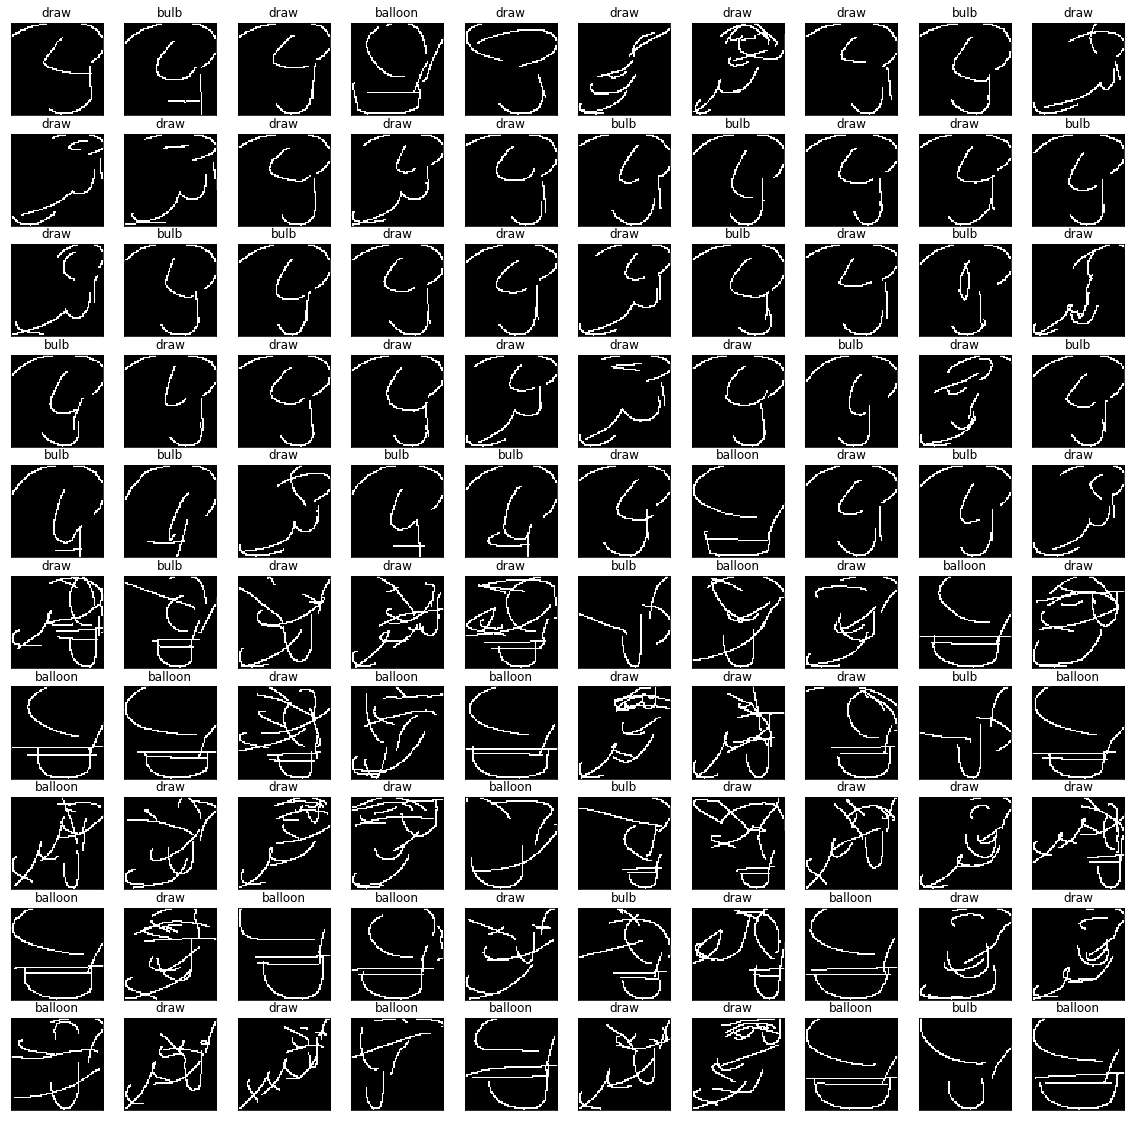

In 100 games, 20 of sketches look like balloon, 23 of sketches look like bulb, 57 of sketches look like others
player1 win 20 games, player2 win 23 games, 57 games draw


In [22]:
pretrain_model = SRNN_Model(hps, model_name='balloon')

max_seq_len = get_max_len(sketches_finetune)
input_sketch = pad_data(sketches_finetune, max_seq_len)
hps.max_seq_len = max_seq_len
hps.learning_rate = 1e-5
finetune_model = SRNN_Model(hps, model_name='balloon-bulb')

print(input_sketch.shape)

sess.run(tf.global_variables_initializer())

pretrain_model.load_model(sess, step=64000)
pretrain_model_2 = SRNN_Model(hps, model_name='bulb')
pretrain_model_2.load_model(sess, step=64000)

ta_model = SRNN_Model(hps, model_name='bulb-balloon-60')
ta_model.load_model(sess)
# assign weights
srcs = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'balloon/')
tars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'balloon-bulb/')
assert len(srcs) == len(tars)
update_ops = []
for src, tar in zip(srcs, tars):
  update_ops.append(tar.assign(src))
sess.run(update_ops)

finetune_model.train(sess, input_sketch, input_sketch, input_sketch, finetune_loss)

result, who_draw_the_strokes, sketches_finetune, finetune_loss = play_game(finetune_model, pretrain_model_2)

INFO:tensorflow:Restoring parameters from ./checkpoints\evaluate_model
player1 draw balloon, player2 draw bulb


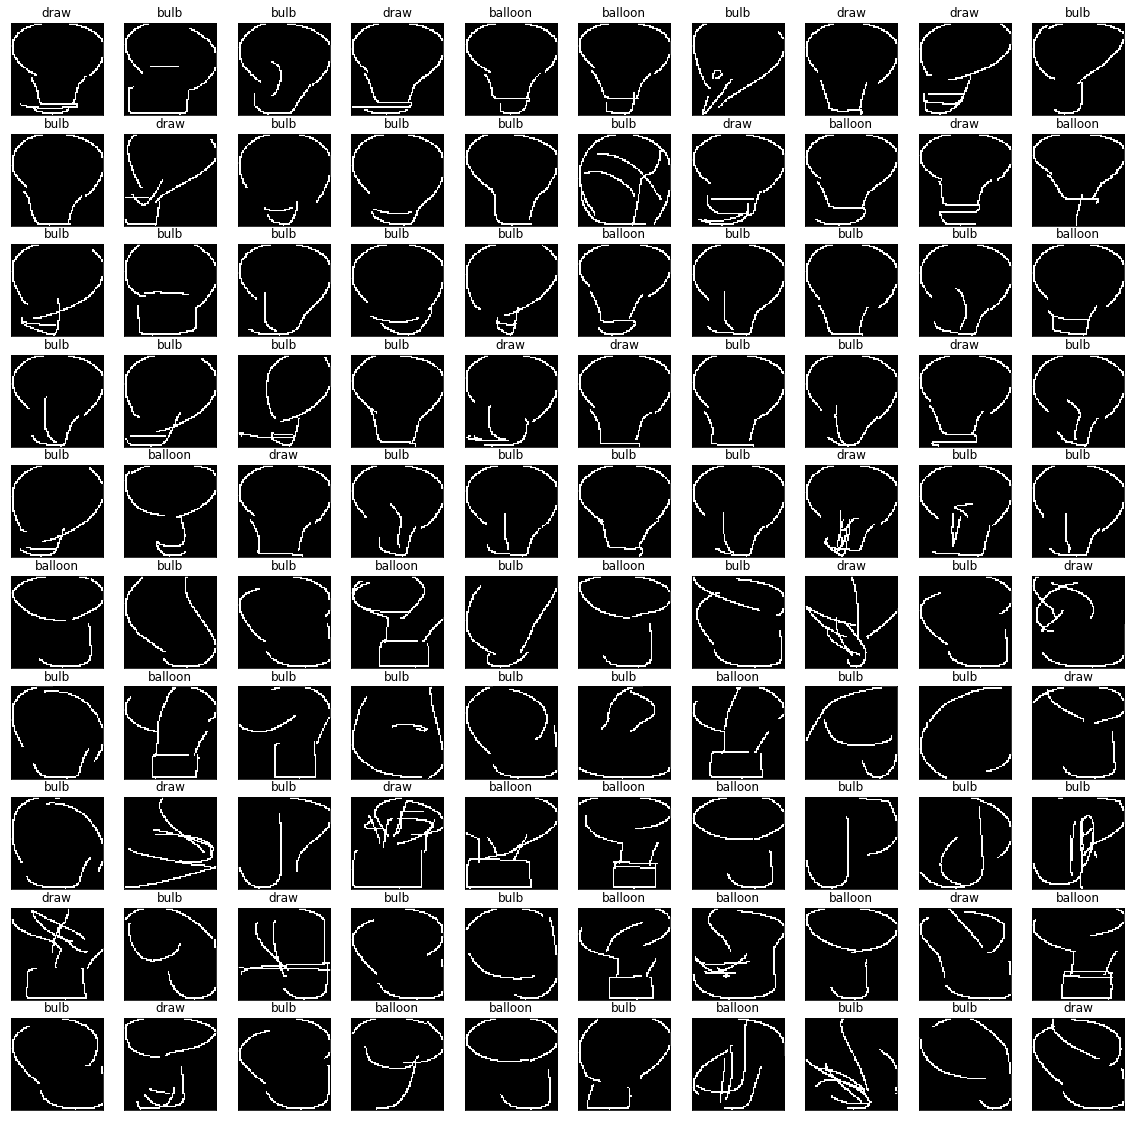

In 100 games, 22 of sketches look like balloon, 56 of sketches look like bulb, 22 of sketches look like others
player1 win 22 games, player2 win 56 games, 22 games draw


In [23]:
result, who_draw_the_strokes, sketches_finetune, finetune_loss = play_game(pretrain_model, ta_model)

INFO:tensorflow:Restoring parameters from ./checkpoints\evaluate_model
player1 draw balloon, player2 draw bulb


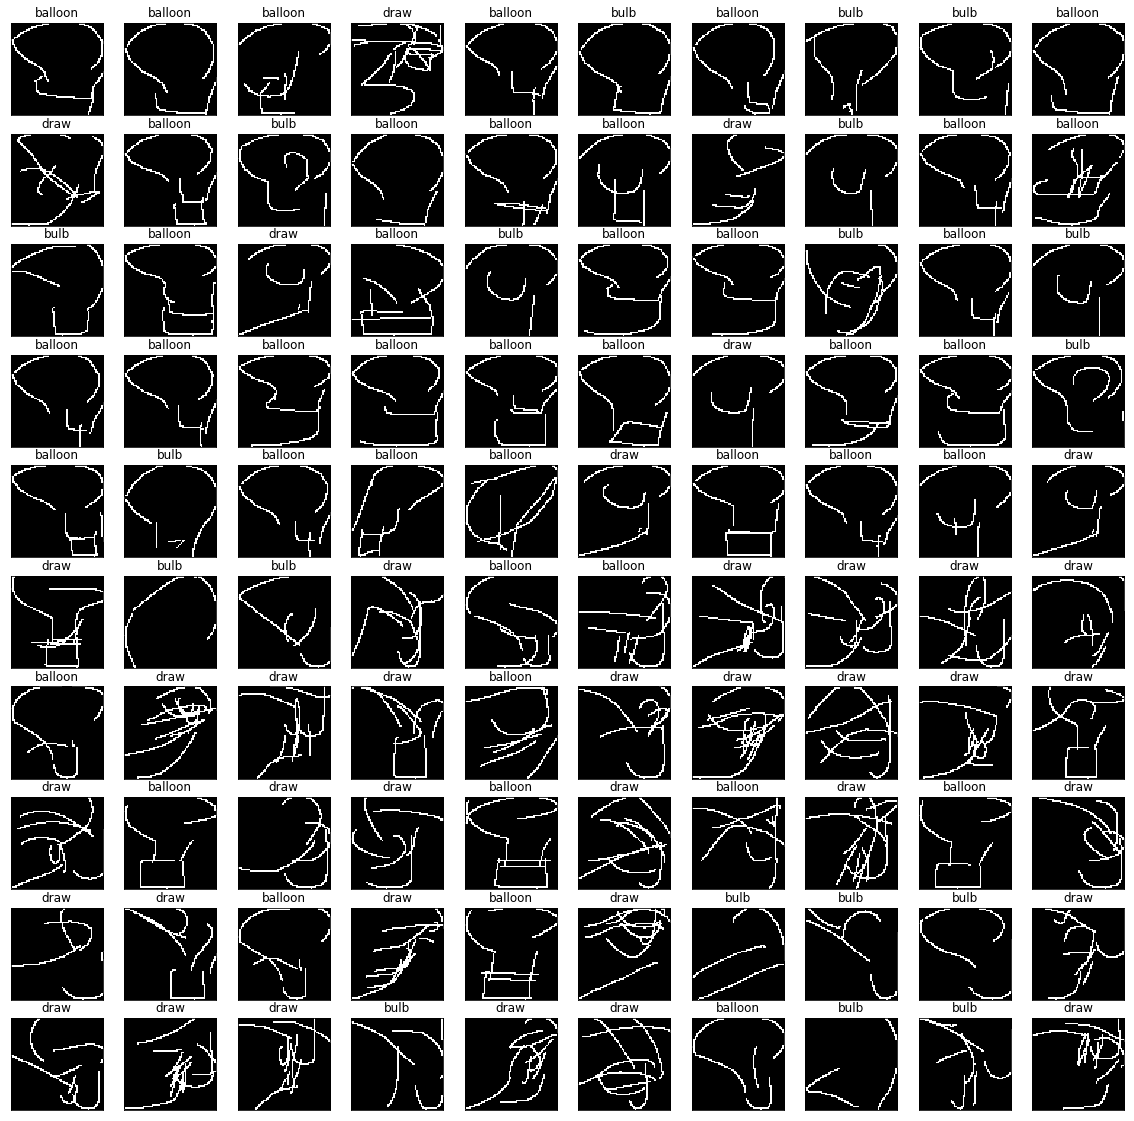

In 100 games, 43 of sketches look like balloon, 19 of sketches look like bulb, 38 of sketches look like others
player1 win 43 games, player2 win 19 games, 38 games draw


In [24]:
result, who_draw_the_strokes, sketches_finetune, finetune_loss = play_game(finetune_model, ta_model)

In [1073]:
finetune_model.save_model(sess)

INFO:tensorflow:model save to ./checkpoints\balloon-bulb


# Conclusion

一開始，我們怎麼也想不透這次的competition和Reinforcement Learning有甚麼關聯，在finetune時，也一直tune不起來。一開始認為，當evaluation model predict出來的結果像我要畫的class的時候，loss應該要越小越好才對，因為表示RNN model所generate出來的stroke很像我想畫的class，在finetune時也不希望做太大的改動。經過與助教提示後， 我們豁然開朗。

policy gradient 的 loss 通常寫成 -log(P) * reward
當 reward>0 的時候，你要minimize loss 的話 P 要越大越好，代表你以後的行為要越像這次的行為。
當 reward=0 的時候，你無法對 P 做改變。 
當 reward<0 的時候，你要minimize loss 的話 P 要越接近0越好，代表你以後的行為要越不像這次的行為。

照著助教給的方向去嘗試，最後就成功了。


謝謝助教們這一學期來不吝嗇的幫助，學到了很多~~